# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [3]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/MyDrive/Polimi/ANNDL/challenge2

Mounted at /gdrive
/gdrive/MyDrive/Polimi/ANNDL/challenge2


## ⚙️ Import Libraries

In [4]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras.models

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from datetime import datetime
import pandas as pd

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [5]:
import pandas as pd

## ⏳ Load the Data

In [6]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]


print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

# Separiamo il train set in training e validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  # 20% per il validation set
)


Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [7]:
category_map = {
  0: 0, #Background
  1: 1, #Soil
  2: 2, #Bedrock
  3: 3, #Sand
  4: 4, #Big Rock
}

In [8]:
def visualize_image_label_pairs(X, y, num_images):
    """
    Visualize pairs of original images and their corresponding label overlays.

    Args:
        X: Array of images (shape: [num_samples, height, width, channels]).
        y: Array of labels (shape: [num_samples, height, width]).
        num_images: Number of image-label pairs to visualize.
    """
    # Imposta il layout della griglia: 2 colonne, num_images righe
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    for i in range(num_images):
        # Estrai l'immagine e la label corrispondente
        image = X[i]
        label = y[i]

        # Mostra l'immagine originale nella prima colonna
        ax = axes[i, 0] if num_images > 1 else axes[0]
        ax.imshow(image.squeeze(), cmap='gray')  # Usa squeeze per immagini grayscale
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

        # Mostra l'immagine con sovrapposizione delle label nella seconda colonna
        ax = axes[i, 1] if num_images > 1 else axes[1]
        ax.imshow(image.squeeze(), cmap='gray')  # Sfondo: immagine originale
        ax.imshow(label, alpha=0.5, cmap='jet')  # Sovrapposizione della label
        ax.axis('off')
        ax.set_title(f"Label Overlay {i+1}")

    plt.tight_layout()
    plt.show()

In [11]:
def visualize_image_label_pairs(X, y, num_images, class_names, reverse=0):
    """
    Visualize pairs of original images and their corresponding label overlays,
    and add a color legend for the labels.

    Args:
        X: Array of images (shape: [num_samples, height, width, channels]).
        y: Array of labels (shape: [num_samples, height, width]).
        num_images: Number of image-label pairs to visualize.
        class_names: List of class names (optional). If provided, a legend will be added.
    """

    if reverse == 1:
        X = X[::-1]
        y = y[::-1]

    # Set up the grid layout: 2 columns, num_images rows
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    # Define a custom colormap for the legend
    if class_names is not None:
        cmap = mcolors.ListedColormap(plt.cm.jet(np.linspace(0, 1, len(class_names))))
        norm = mcolors.BoundaryNorm(np.arange(len(class_names)+1), len(class_names))
    else:
        cmap = 'jet'
        norm = None

    for i in range(num_images):
        # Extract the image and its corresponding label
        image = X[i]
        label = y[i]

        # Show the original image in the first column
        ax = axes[i, 0] if num_images > 1 else axes[0]
        ax.imshow(image.squeeze(), cmap='gray')  # Use squeeze for grayscale images
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

        # Show the image with the label overlay in the second column
        ax = axes[i, 1] if num_images > 1 else axes[1]
        ax.imshow(image.squeeze(), cmap='gray')  # Background: original image
        ax.imshow(label, alpha=0.5, cmap=cmap, norm=norm)  # Label overlay
        ax.axis('off')
        ax.set_title(f"Label Overlay {i+1}")

    # Add the legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(class_names))]
        plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

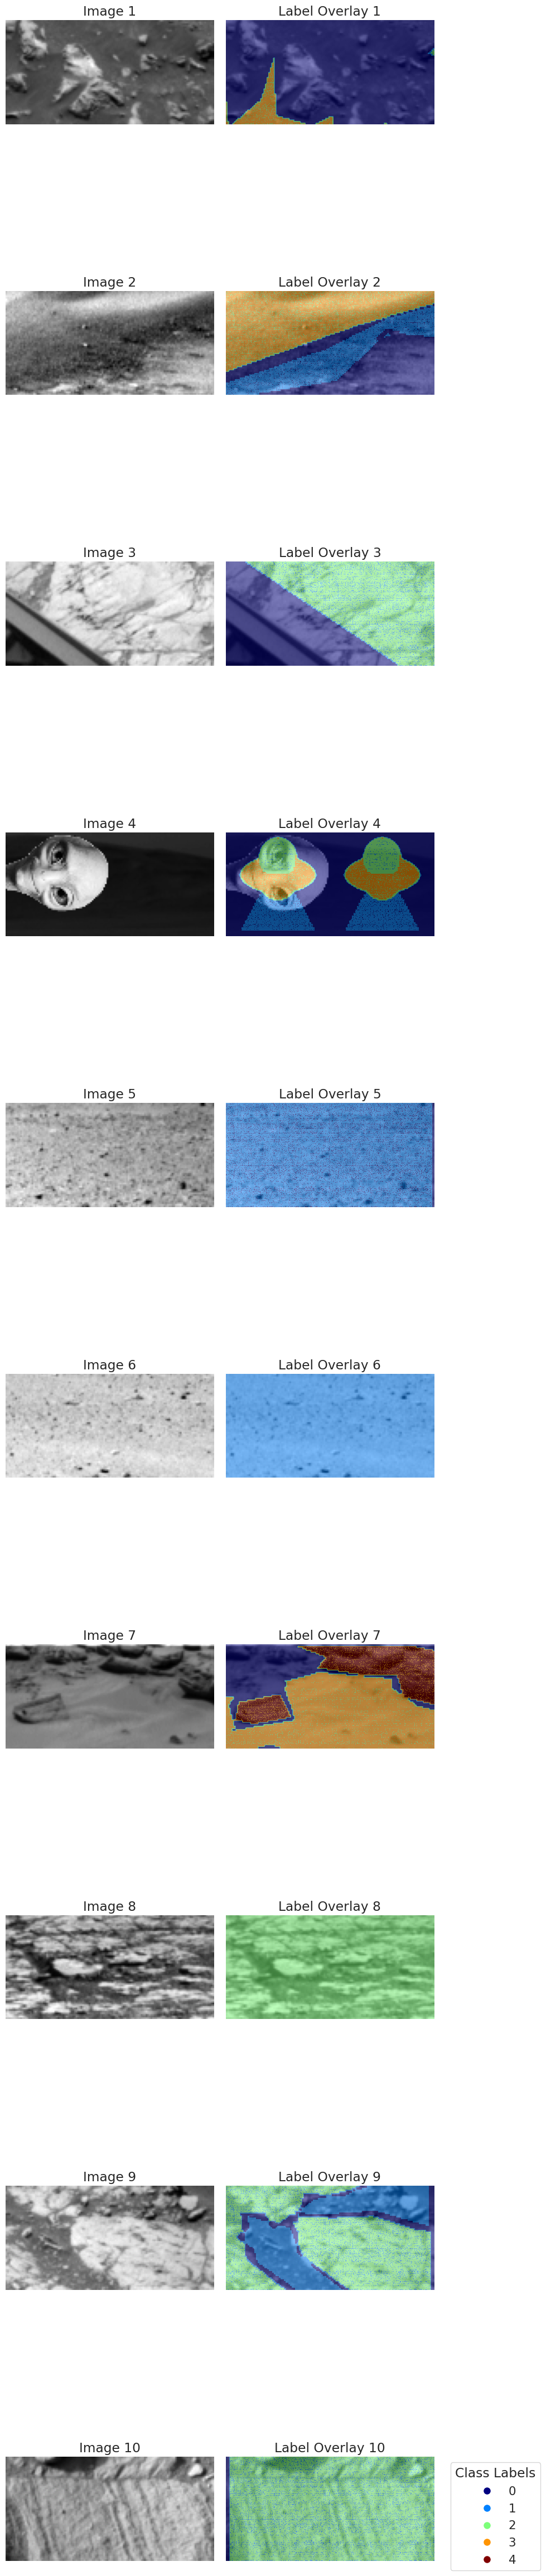

In [12]:
visualize_image_label_pairs(X_train, y_train, num_images=10, class_names=category_map, reverse=1)

In [ ]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.round(label)  # Round to nearest integer
    label = tf.cast(label, tf.int32)

    return image, label

In [ ]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [ ]:
@tf.function
def apply_augmentation(image, label, seed=None):
    """Apply consistent random augmentation to grayscale images."""
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure image has 3 dimensions (height, width, 1 channel for grayscale)
    if len(image.shape) == 2:  # If it's grayscale (H, W), expand to (H, W, 1)
        image = tf.expand_dims(image, axis=-1)
        label = tf.expand_dims(label, axis=-1)

    # Apply random horizontal flip
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    # Apply random rotation using `tf.image` methods
    rotation_angle = tf.random.uniform([], minval=-10, maxval=10, seed=seed)  # Angle in degrees
    rotation_angle_rad = rotation_angle * tf.constant(3.14159265 / 180, dtype=tf.float32)  # Convert to radians
    k_rotations = tf.cast(rotation_angle_rad // (3.14159265 / 2), tf.int32)
    image = tf.image.rot90(image, k=k_rotations)
    label = tf.image.rot90(label, k=k_rotations)

    # Apply random zoom
    zoom_factor = tf.random.uniform([], minval=0.9, maxval=1.1, seed=seed)
    target_height = tf.cast(tf.cast(tf.shape(image)[0], tf.float32) * zoom_factor, tf.int32)
    target_width = tf.cast(tf.cast(tf.shape(image)[1], tf.float32) * zoom_factor, tf.int32)
    image = tf.image.resize(image, [target_height, target_width])
    label = tf.image.resize(label, [target_height, target_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Ensure size consistency after augmentation
    target_height, target_width = 64, 128  # Replace with your actual target size
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    label = tf.image.resize_with_crop_or_pad(label, target_height, target_width)

    # Ensure label values remain integers
    label = tf.round(label)

    return image, label

In [ ]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: apply_augmentation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 5

# Set maximum number of training epochs
EPOCHS = 50

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    seed=seed
)


# Debug: Print unique values of the label to verify
tf.print("Unique label values (rounded and casted):", tf.unique(tf.reshape(y_train[4], [-1]))[0])

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Unique label values (rounded and casted): [0 2]
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


In [ ]:
for images, labels in train_dataset.take(1):
    unique_labels = np.unique(labels.numpy())
    print("Unique label values in train_dataset:", unique_labels)

    # Verifica se tutti i valori sono interi
    if np.all(unique_labels == unique_labels.astype(int)):
        print("All label values are integers.")
    else:
        print("Warning: Found non-integer label values.")

Unique label values in train_dataset: [0 1 2 3 4]
All label values are integers.


Visualizing examples from the training set:


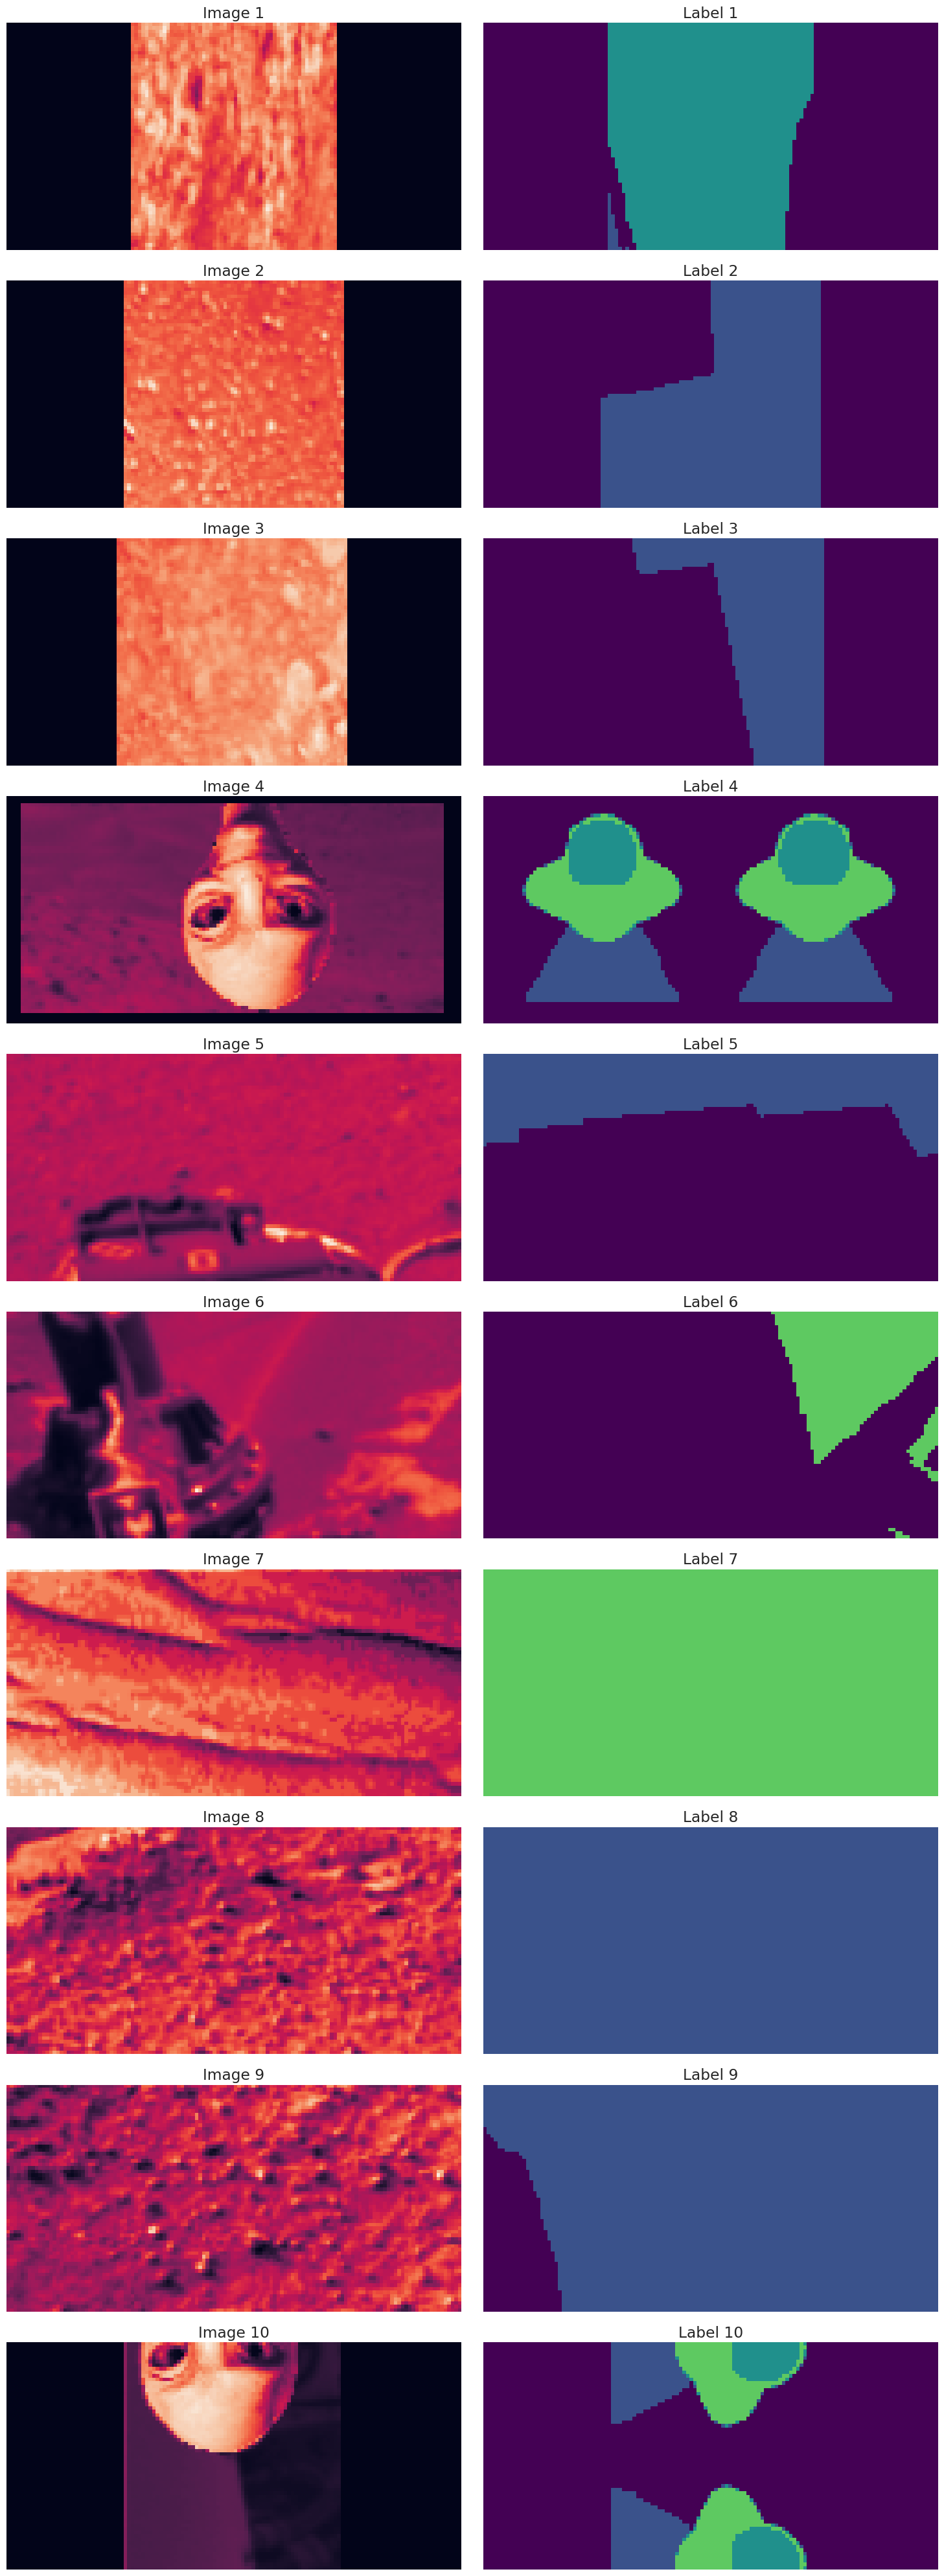

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=10)

## 🛠️ Train and Save the Model

In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D(name='maxpool1')(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D(name='maxpool2')(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D(name='upsample1')(bottleneck)
    u1 = tfkl.Concatenate(name='concat1')([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D(name='upsample2')(u1)
    u2 = tfkl.Concatenate(name='concat2')([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

# Esempio di utilizzo
unet_model = get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes)
unet_model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv1         │ (None, 64, 128, 32)    │            320 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn1           │ (None, 64, 128, 32)    │            128 │ down_block1_conv1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation1   │ (None, 64, 128, 32)    │              0 │ down_block1_bn1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv2         │ (None, 64, 128, 32)    │          9,248 │ down_block1_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn2           │ (None, 64, 128, 32)    │            128 │ down_block1_conv2[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation2   │ (None, 64, 128, 32)    │              0 │ down_block1_bn2[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool1 (MaxPooling2D)   │ (None, 32, 64, 32)     │              0 │ down_block1_activatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_conv1         │ (None, 32, 64, 64)     │         18,496 │ maxpool1[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_bn1           │ (None, 32, 64, 64)     │            256 │ down_block2_conv1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_activation1   │ (None, 32, 64, 64)     │              0 │ down_block2_bn1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_conv2         │ (None, 32, 64, 64)     │         36,928 │ down_block2_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_bn2           │ (None, 32, 64, 64)     │            256 │ down_block2_conv2[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_activation2   │ (None, 32, 64, 64)     │              0 │ down_block2_bn2[0][0]  │
│ (Activation)         

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ maxpool1               │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ maxpool1[0][0]      │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

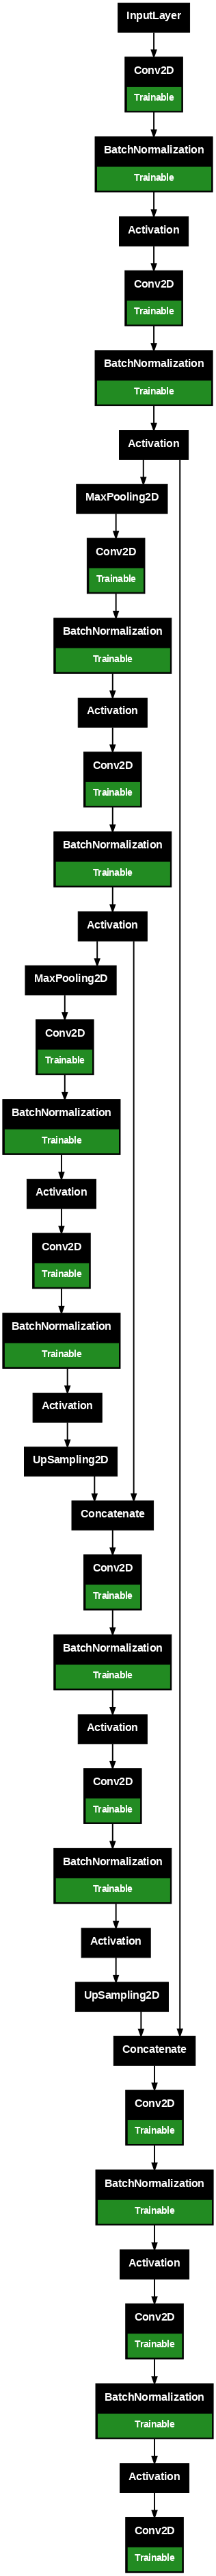

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val[0], y_val[0])

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.6116 - loss: 0.8936 - mean_iou: 0.2371

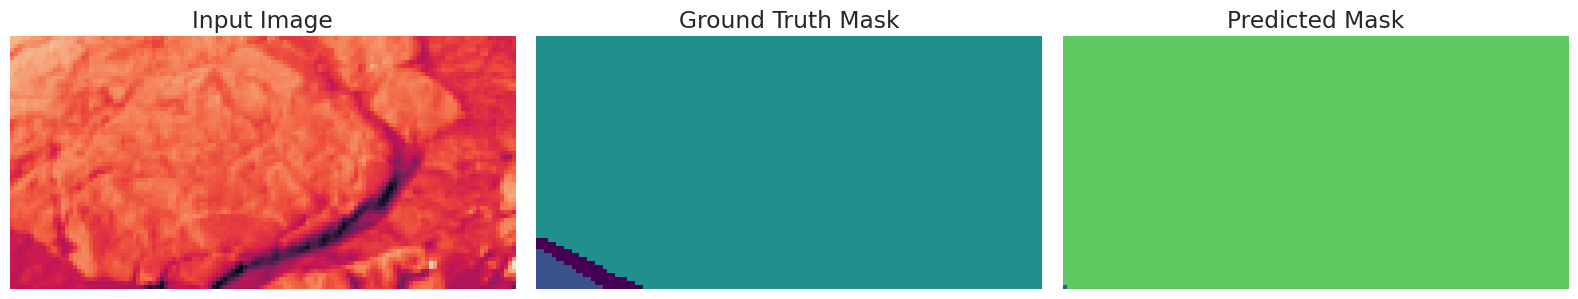

33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 803ms/step - accuracy: 0.6126 - loss: 0.8922 - mean_iou: 0.2377 - val_accuracy: 0.2030 - val_loss: 2.4067 - val_mean_iou: 0.0684
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6741 - loss: 0.7930 - mean_iou: 0.2925 - val_accuracy: 0.2030 - val_loss: 2.4322 - val_mean_iou: 0.0683
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.7048 - loss: 0.7402 - mean_iou: 0.3205 - val_accuracy: 0.2030 - val_loss: 3.0267 - val_mean_iou: 0.0547
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.6991 - loss: 0.7462 - mean_iou: 0.3192 - val_accuracy: 0.2029 - val_loss: 3.2046 - val_mean_iou: 0.0547
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7160 - loss: 0.7157 - mean_iou: 0.3330 - val_accuracy: 0.2030 - val_loss: 3.2686 - val_mean_iou: 0.0547
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7214 - loss: 0.6998 - mean_iou: 0.3417

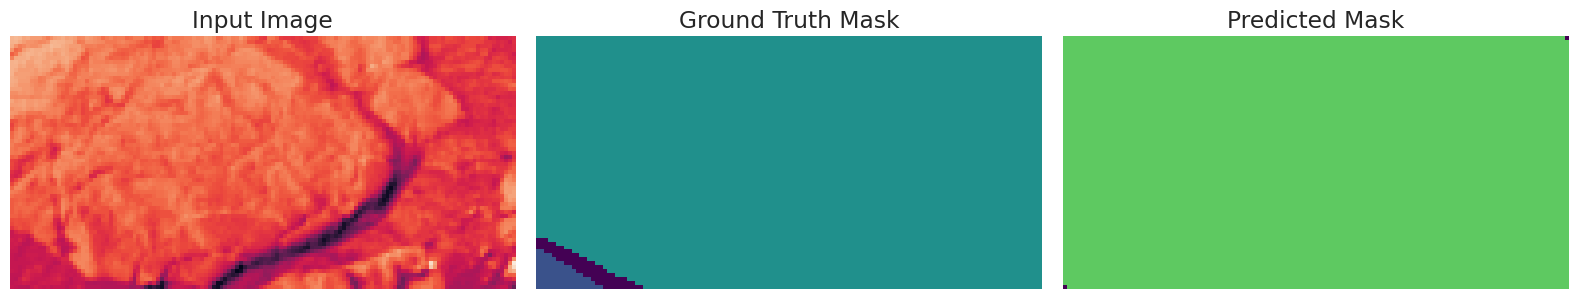

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7216 - loss: 0.6993 - mean_iou: 0.3417 - val_accuracy: 0.2191 - val_loss: 2.1436 - val_mean_iou: 0.0656
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.7263 - loss: 0.6954 - mean_iou: 0.3475 - val_accuracy: 0.2143 - val_loss: 2.7867 - val_mean_iou: 0.0628
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.7398 - loss: 0.6627 - mean_iou: 0.3643 - val_accuracy: 0.2221 - val_loss: 2.7824 - val_mean_iou: 0.0677
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.7386 - loss: 0.6591 - mean_iou: 0.3628 - val_accuracy: 0.2130 - val_loss: 2.9954 - val_mean_iou: 0.0609
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.7428 - loss: 0.6511 - mean_iou: 0.3701 - val_accuracy: 0.2909 - val_loss: 1.8578 - val_mean_iou: 0.1099
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7487 - loss: 0.6408 - mean_iou: 0.3773

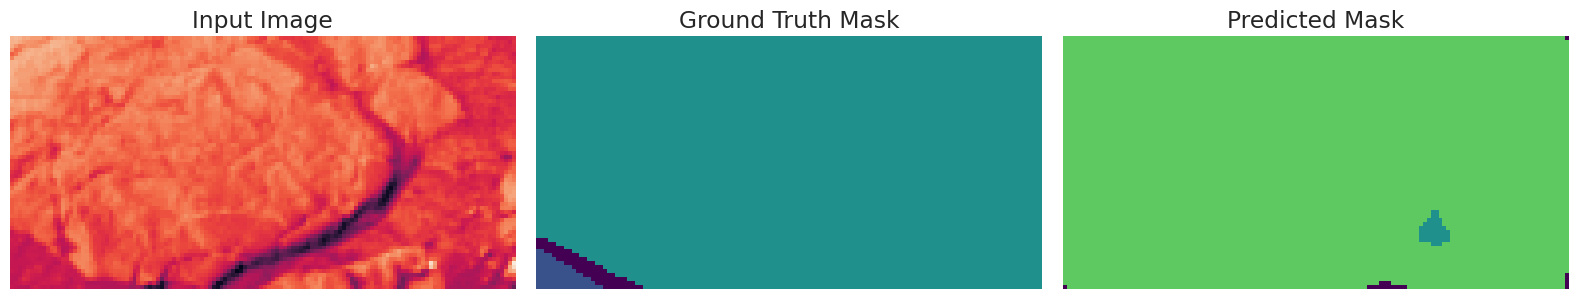

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7490 - loss: 0.6401 - mean_iou: 0.3774 - val_accuracy: 0.3591 - val_loss: 1.6554 - val_mean_iou: 0.1662
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7557 - loss: 0.6254 - mean_iou: 0.3812 - val_accuracy: 0.3900 - val_loss: 1.5309 - val_mean_iou: 0.1814
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.7516 - loss: 0.6251 - mean_iou: 0.3780 - val_accuracy: 0.4932 - val_loss: 1.2252 - val_mean_iou: 0.2550
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7584 - loss: 0.6215 - mean_iou: 0.3791 - val_accuracy: 0.5513 - val_loss: 1.0707 - val_mean_iou: 0.3296
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.7614 - loss: 0.6090 - mean_iou: 0.3904 - val_accuracy: 0.5425 - val_loss: 1.1003 - val_mean_iou: 0.3146
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7665 - loss: 0.6016 - mean_iou: 0.3998

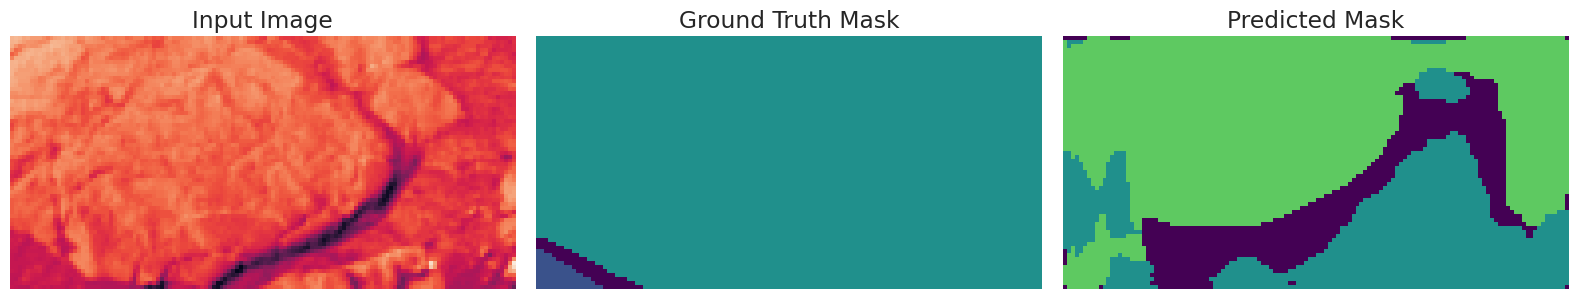

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7667 - loss: 0.6011 - mean_iou: 0.3998 - val_accuracy: 0.4227 - val_loss: 1.5672 - val_mean_iou: 0.2022
Epoch 17/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.7558 - loss: 0.6218 - mean_iou: 0.3809 - val_accuracy: 0.4367 - val_loss: 1.5335 - val_mean_iou: 0.2047
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7572 - loss: 0.6131 - mean_iou: 0.3909 - val_accuracy: 0.5799 - val_loss: 1.0616 - val_mean_iou: 0.3214
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.7667 - loss: 0.5985 - mean_iou: 0.3983 - val_accuracy: 0.6655 - val_loss: 0.8596 - val_mean_iou: 0.3849
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7697 - loss: 0.5886 - mean_iou: 0.4031 - val_accuracy: 0.6693 - val_loss: 0.8330 - val_mean_iou: 0.4138
Epoch 21/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7701 - loss: 0.5763 - mean_iou: 0.4068

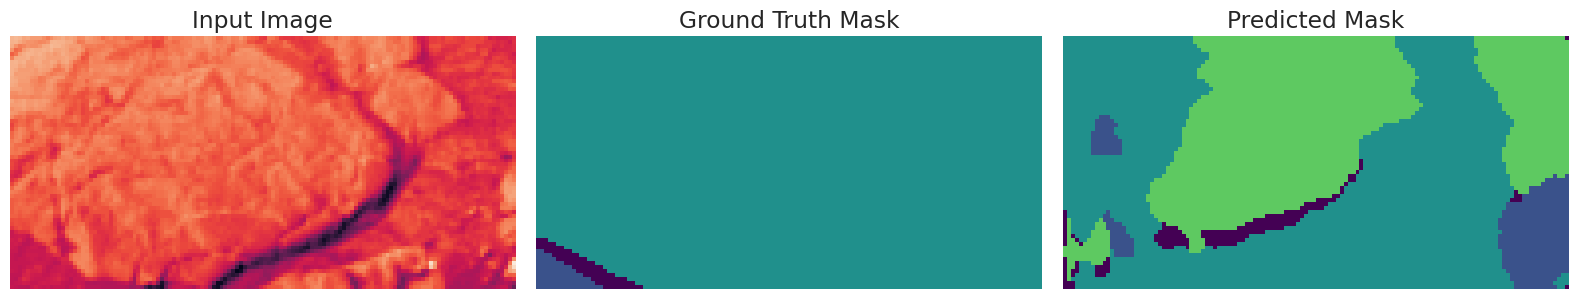

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.7705 - loss: 0.5758 - mean_iou: 0.4068 - val_accuracy: 0.5696 - val_loss: 1.1532 - val_mean_iou: 0.3174
Epoch 22/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7719 - loss: 0.5815 - mean_iou: 0.4092 - val_accuracy: 0.5917 - val_loss: 1.0434 - val_mean_iou: 0.3195
Epoch 23/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.7764 - loss: 0.5716 - mean_iou: 0.4133 - val_accuracy: 0.5030 - val_loss: 1.4233 - val_mean_iou: 0.2490
Epoch 24/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7886 - loss: 0.5469 - mean_iou: 0.4230 - val_accuracy: 0.6789 - val_loss: 0.8408 - val_mean_iou: 0.3897
Epoch 25/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7800 - loss: 0.5722 - mean_iou: 0.4155 - val_accuracy: 0.5743 - val_loss: 1.1615 - val_mean_iou: 0.2959
Epoch 26/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7838 - loss: 0.5575 - mean_iou: 0.4170

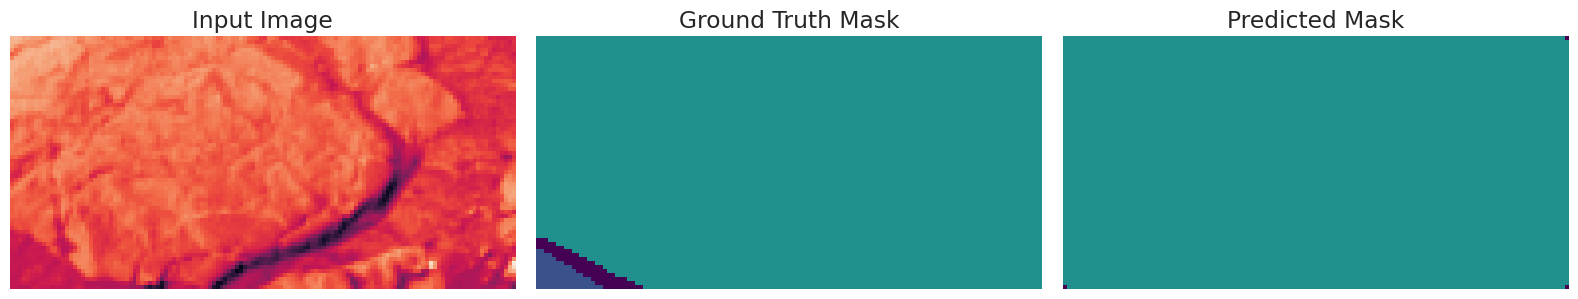

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7840 - loss: 0.5571 - mean_iou: 0.4170 - val_accuracy: 0.5912 - val_loss: 1.0801 - val_mean_iou: 0.3277
Epoch 27/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7824 - loss: 0.5626 - mean_iou: 0.4130 - val_accuracy: 0.6420 - val_loss: 0.8941 - val_mean_iou: 0.3480
Epoch 28/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.7832 - loss: 0.5533 - mean_iou: 0.4190 - val_accuracy: 0.5682 - val_loss: 1.1716 - val_mean_iou: 0.2820
Epoch 29/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.7831 - loss: 0.5605 - mean_iou: 0.4140 - val_accuracy: 0.5813 - val_loss: 1.0341 - val_mean_iou: 0.2917
Final validation Mean Intersection Over Union: 41.38%


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model1.keras'
model.save(model_filename)

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_241201_171102.keras


In [ ]:
del model

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
model = tfk.models.load_model('model1.keras', compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241201_171102.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```